In [84]:
%run './model/multi_corpus.py'
%run './constants.py'

%matplotlib inline

from matplotlib import cm

from scipy.stats import powerlaw, lognorm
from scipy.optimize import curve_fit

from scipy.stats import kstest
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [75]:
corpora = co_occurence_graphs(10_000)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 1378 nodes and 10000 edges
Geometry Graph with 983 nodes and 10000 edges
Geophysics Graph with 896 nodes and 10000 edges
Economics Graph with 996 nodes and 10000 edges
Language & Linguistics Graph with 1010 nodes and 10000 edges
Probability & Statistics Graph with 912 nodes and 10000 edges
Material Engineering Graph with 881 nodes and 10000 edges
Artificial Intelligence Graph with 951 nodes and 10000 edges
Sociology Graph with 943 nodes and 10000 edges
International Business Graph with 822 nodes and 10000 edges
Political Science Graph with 1037 nodes and 10000 edges
Genetics & Genomics Graph with 1328 nodes and 10000 edges
Immunology Graph with 1595 nodes and 10000 edges
Human Resources & Organizations Graph with 1054 nodes and 10000 edges
Ethnic & Cultural Studies Graph with 919 nodes and 10000 edges
Neurology Graph with 854 nodes and 10000 edges


KS Powerlaw: 0.998 (0.0)
KS Lognorm: 0.855 (0.0)
MSE Powerlaw: 0.066
MSE Lognorm: 0.006
MAPE Powerlaw: 0.734
MAPE Lognorm: 0.819


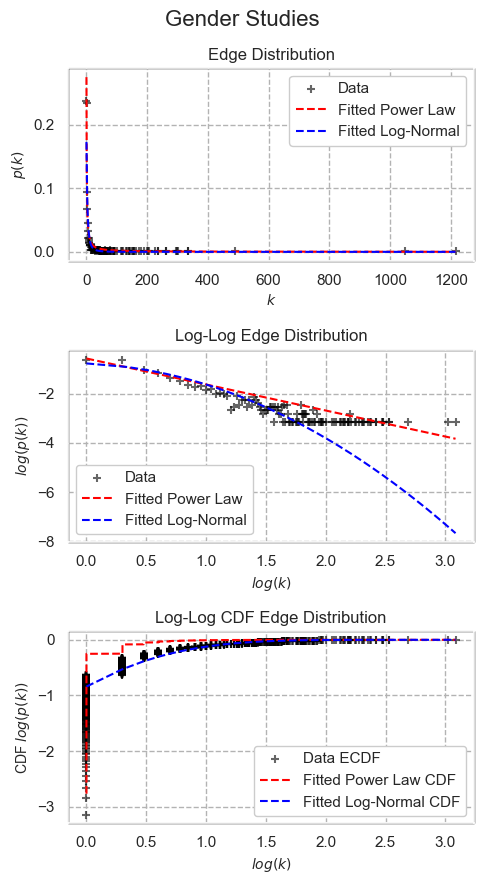

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.87 (0.0)
MSE Powerlaw: 0.095
MSE Lognorm: 0.004
MAPE Powerlaw: 0.892
MAPE Lognorm: 0.681


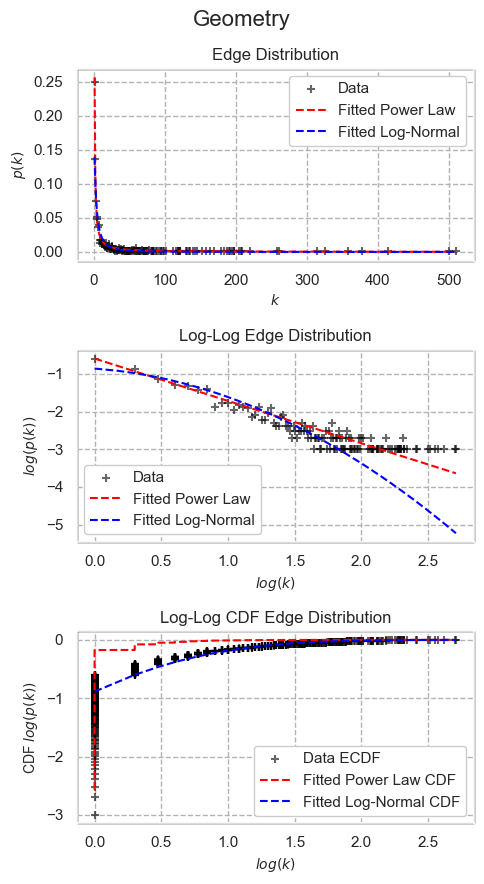

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.854 (0.0)
MSE Powerlaw: 0.102
MSE Lognorm: 0.005
MAPE Powerlaw: 0.892
MAPE Lognorm: 0.774


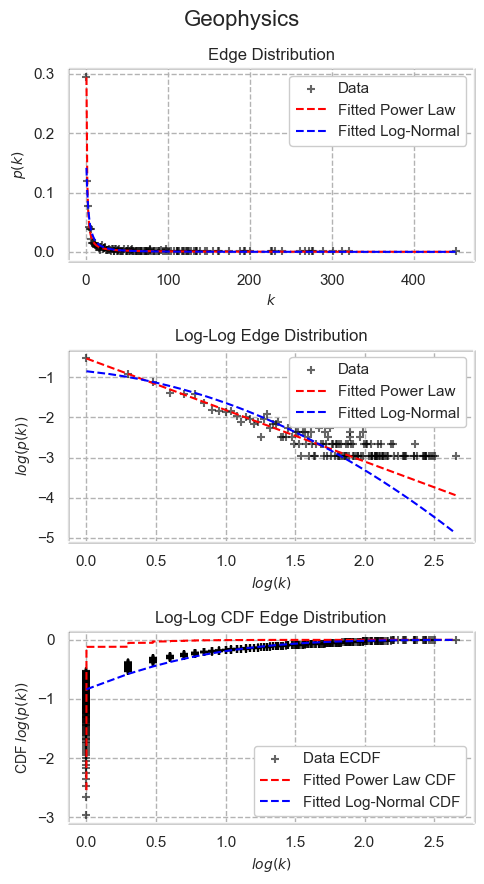

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.872 (0.0)
MSE Powerlaw: 0.091
MSE Lognorm: 0.003
MAPE Powerlaw: 0.878
MAPE Lognorm: 0.67


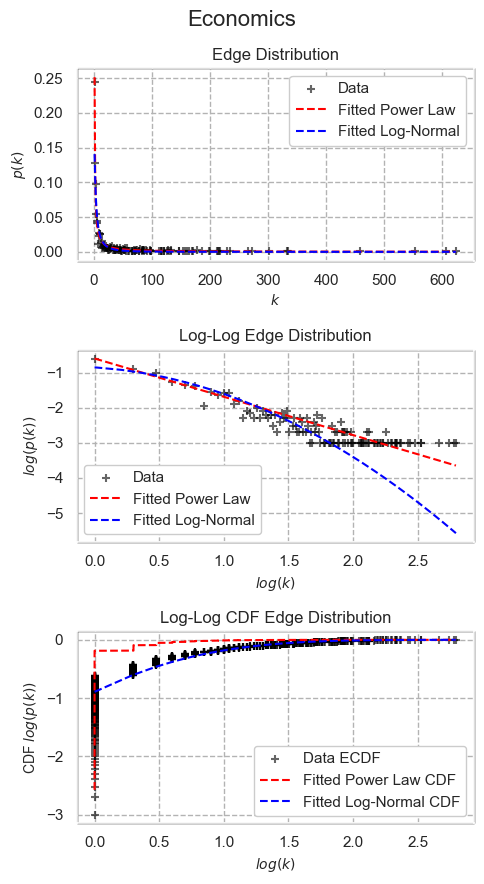

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.861 (0.0)
MSE Powerlaw: 0.091
MSE Lognorm: 0.004
MAPE Powerlaw: 0.858
MAPE Lognorm: 0.74


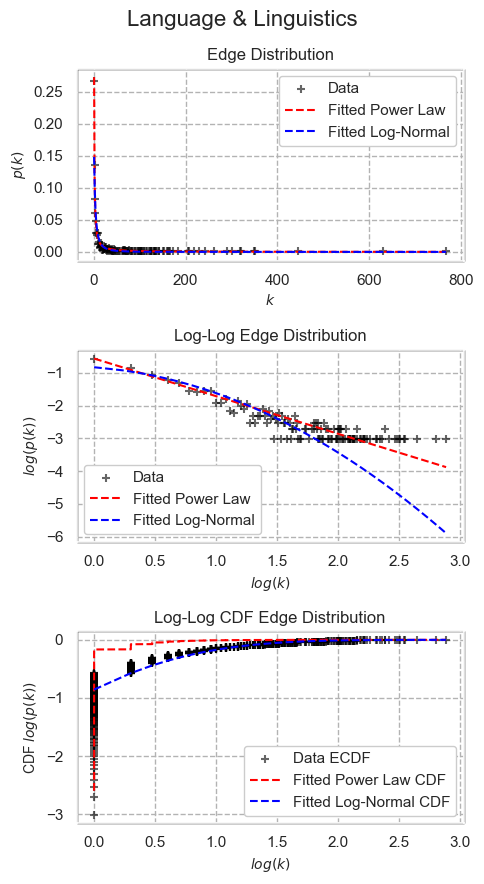

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.859 (0.0)
MSE Powerlaw: 0.099
MSE Lognorm: 0.004
MAPE Powerlaw: 0.889
MAPE Lognorm: 0.741


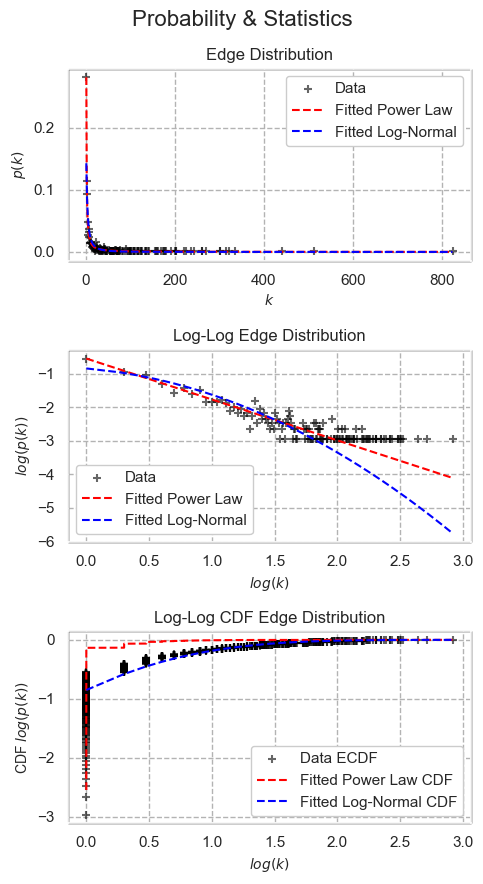

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.883 (0.0)
MSE Powerlaw: 0.104
MSE Lognorm: 0.003
MAPE Powerlaw: 0.952
MAPE Lognorm: 0.588


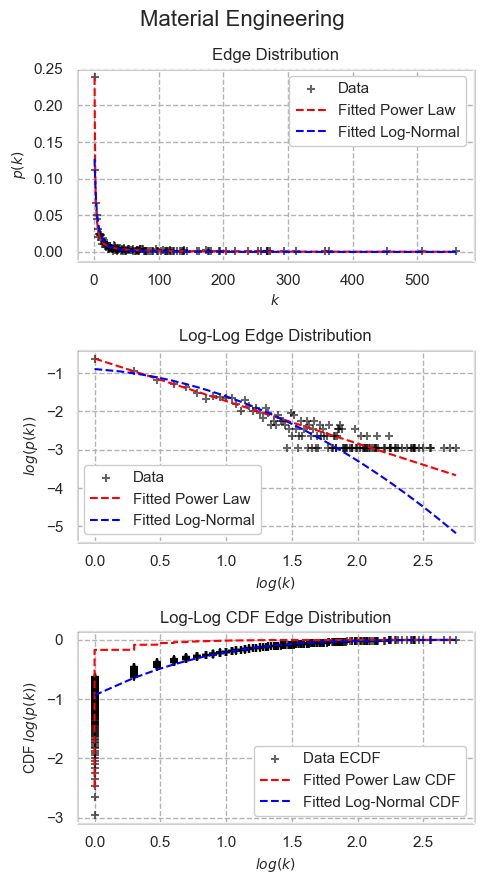

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.864 (0.0)
MSE Powerlaw: 0.101
MSE Lognorm: 0.003
MAPE Powerlaw: 0.902
MAPE Lognorm: 0.706


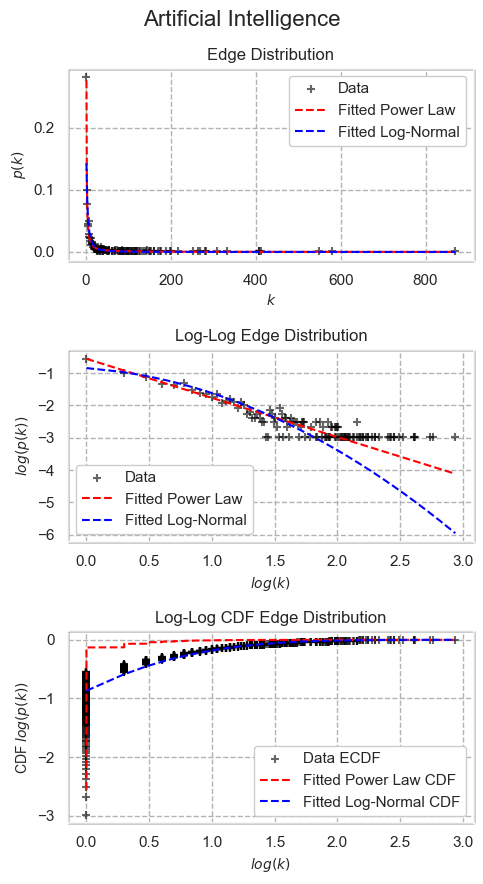

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.848 (0.0)
MSE Powerlaw: 0.099
MSE Lognorm: 0.006
MAPE Powerlaw: 0.866
MAPE Lognorm: 0.816


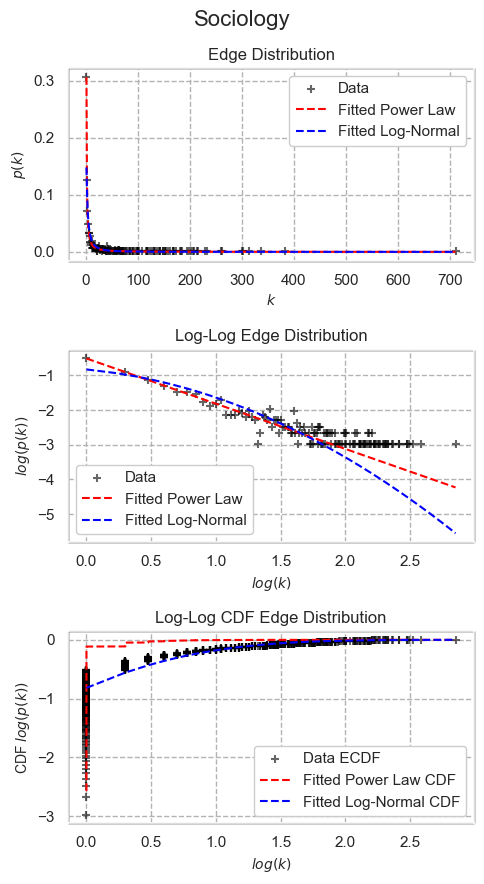

KS Powerlaw: 0.995 (0.0)
KS Lognorm: 0.877 (0.0)
MSE Powerlaw: 0.1
MSE Lognorm: 0.003
MAPE Powerlaw: 0.931
MAPE Lognorm: 0.624


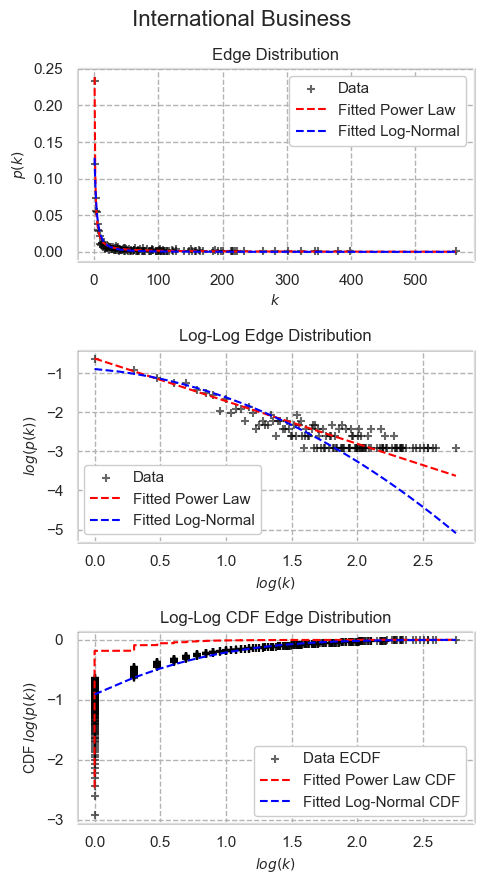

KS Powerlaw: 0.997 (0.0)
KS Lognorm: 0.855 (0.0)
MSE Powerlaw: 0.089
MSE Lognorm: 0.005
MAPE Powerlaw: 0.841
MAPE Lognorm: 0.778


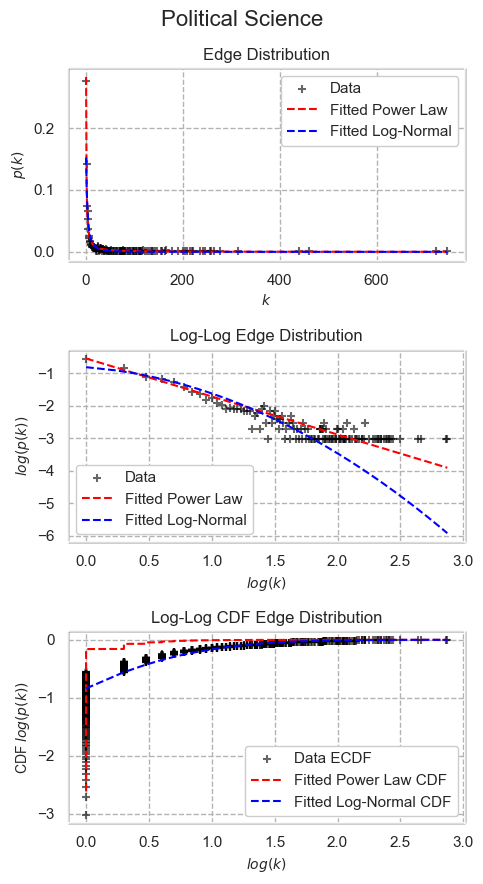

KS Powerlaw: 0.998 (0.0)
KS Lognorm: 0.833 (0.0)
MSE Powerlaw: 0.082
MSE Lognorm: 0.006
MAPE Powerlaw: 0.767
MAPE Lognorm: 0.952


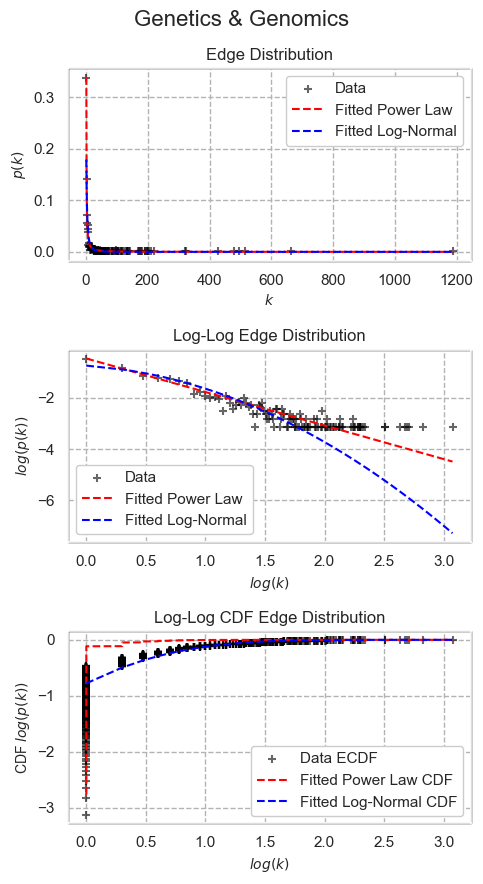

KS Powerlaw: 0.998 (0.0)
KS Lognorm: 0.777 (0.0)
MSE Powerlaw: 0.066
MSE Lognorm: 0.015
MAPE Powerlaw: 0.611
MAPE Lognorm: 1.37


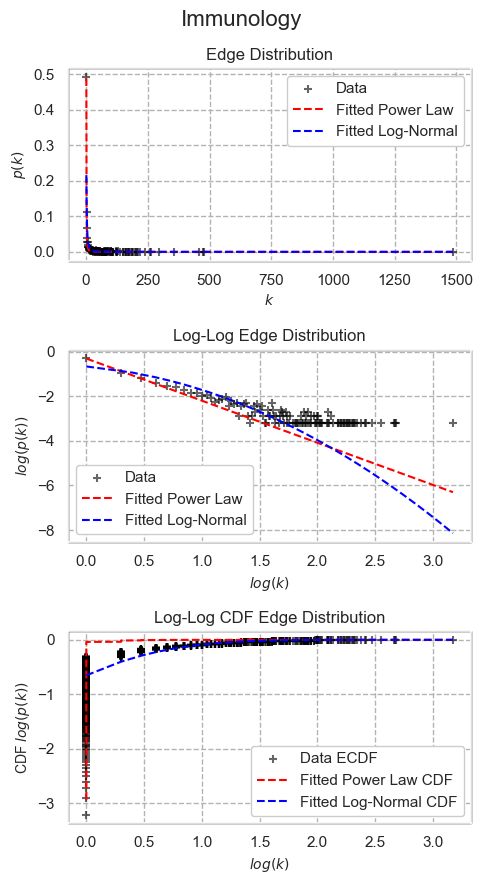

KS Powerlaw: 0.997 (0.0)
KS Lognorm: 0.849 (0.0)
MSE Powerlaw: 0.093
MSE Lognorm: 0.005
MAPE Powerlaw: 0.844
MAPE Lognorm: 0.817


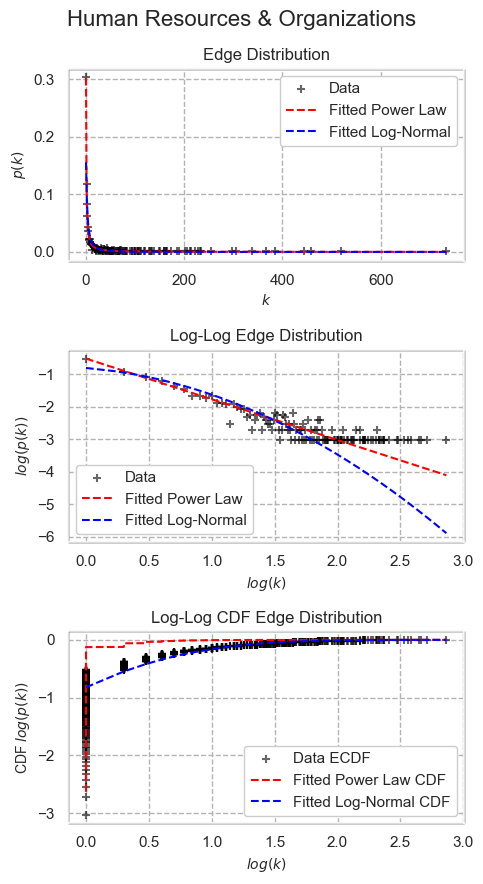

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.885 (0.0)
MSE Powerlaw: 0.087
MSE Lognorm: 0.003
MAPE Powerlaw: 0.884
MAPE Lognorm: 0.583


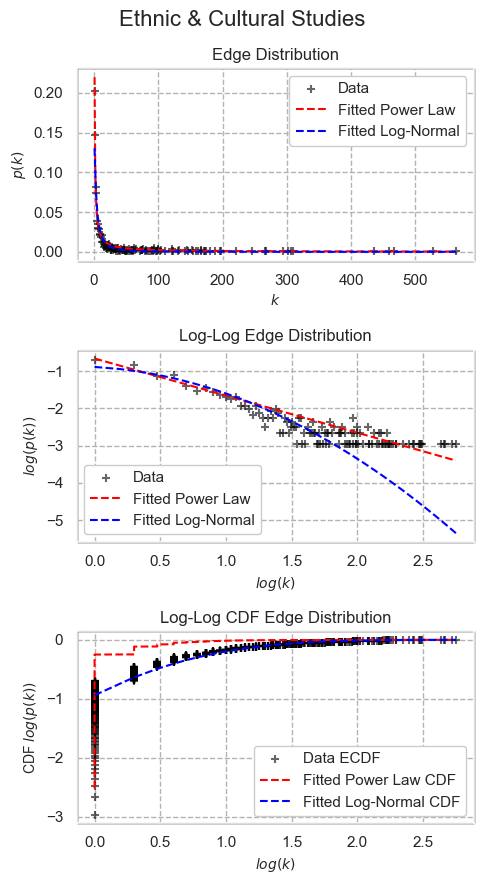

KS Powerlaw: 0.996 (0.0)
KS Lognorm: 0.856 (0.0)
MSE Powerlaw: 0.108
MSE Lognorm: 0.005
MAPE Powerlaw: 0.915
MAPE Lognorm: 0.753


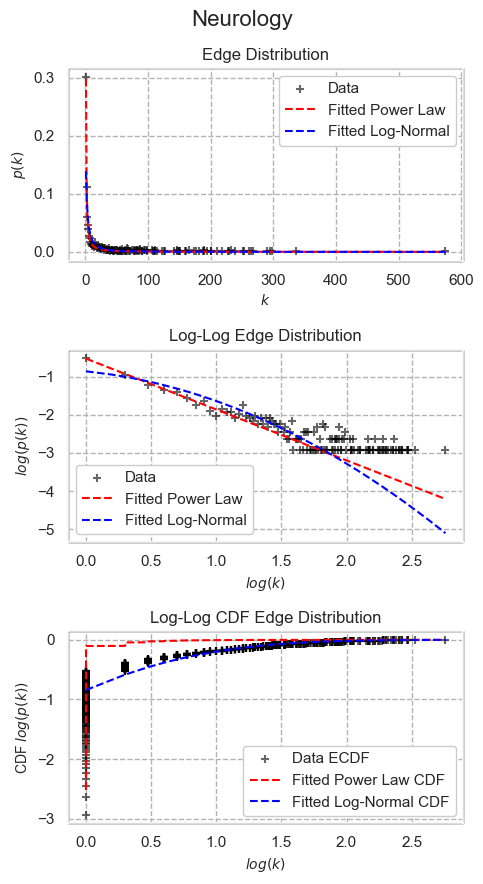

In [105]:
for field_name, G in Gs.items():

    data = list(map(lambda tup: tup[1], G.degree()))

    unique, counts = np.unique(data, return_counts=True)
    probabilities = counts / np.sum(counts)

    x = np.linspace(min(data), max(data), 1000)

    # Fit powerlaw
    power_law_func = lambda x, a, b: a * np.power(x, b)
    params_power_law, covariance = curve_fit(power_law_func, unique, probabilities, maxfev=10000)

    # Fit log-normal
    shape, loc, scale = lognorm.fit(data, floc=0)
    pdf_lognorm = lognorm.pdf(x, shape, loc, scale)

    data_sorted = np.sort(data)
    ecdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    cdf_power_law = np.cumsum(power_law_func(np.sort(data), *params_power_law))
    cdf_power_law /= cdf_power_law[-1]  # Normalize

    cdf_lognorm = lognorm.cdf(np.sort(data), shape, loc, scale)

    ks_stat_power_law, ks_p_power_law = kstest(ecdf_values, lambda x: np.interp(x, data_sorted, cdf_power_law))
    ks_stat_lognorm, ks_p_lognorm = kstest(ecdf_values, lambda x: np.interp(x, data_sorted, cdf_lognorm))

    # FIT

    print(f'KS Powerlaw: {round(ks_stat_power_law, 3)} ({ks_p_power_law})')
    print(f'KS Lognorm: {round(ks_stat_lognorm, 3)} ({ks_p_lognorm})')

    mse_power_law = mean_squared_error(ecdf_values, cdf_power_law)
    mse_lognorm = mean_squared_error(ecdf_values, cdf_lognorm)

    print('MSE Powerlaw:', round(mse_power_law, 3))
    print('MSE Lognorm:', round(mse_lognorm, 3))

    mape_power_law = mean_absolute_percentage_error(ecdf_values, cdf_power_law)
    mape_lognorm = mean_absolute_percentage_error(ecdf_values, cdf_lognorm)

    print('MAPE Powerlaw:', round(mape_power_law, 3))
    print('MAPE Lognorm:', round(mape_lognorm, 3))

    # Plotting with fitted Power Law and Log-Normal on the regular scatterplot
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 9))

    # 1. Regular scatterplot
    axes[0].scatter(unique, probabilities, marker='+', color='black', alpha=0.6, label='Data')
    axes[0].plot(unique, power_law_func(unique, *params_power_law), color='red', linestyle='--', label='Fitted Power Law')
    axes[0].plot(x, lognorm.pdf(x, shape, loc, scale), color='blue', linestyle='--', label='Fitted Log-Normal')
    # axes[0].grid()
    axes[0].set_xlabel('$k$', fontsize=10)
    axes[0].set_ylabel('$p(k)$', fontsize=10)
    axes[0].set_title('Edge Distribution', fontsize=12)
    axes[0].grid(True, which="both", ls="--", c='0.7')
    axes[0].set_facecolor('white')
    axes[0].patch.set_edgecolor('black')
    axes[0].patch.set_linewidth(1)  
    axes[0].legend(facecolor='white', framealpha=1)

    # 2. Log-log scale scatterplot
    axes[1].scatter(np.log10(unique), np.log10(probabilities), marker='+', color='black', alpha=0.6, label='Data')
    axes[1].plot(np.log10(unique), np.log10(power_law_func(unique, *params_power_law)), color='red', linestyle='--', label='Fitted Power Law')
    axes[1].plot(np.log10(x), np.log10(pdf_lognorm), color='blue', linestyle='--', label='Fitted Log-Normal')
    axes[1].set_xlabel('$log(k)$', fontsize=10)
    axes[1].set_ylabel('$log(p(k))$', fontsize=10)
    axes[1].set_title('Log-Log Edge Distribution', fontsize=12)
    axes[1].grid(True, which="both", ls="--", c='0.7')
    axes[1].set_facecolor('white')
    axes[1].patch.set_edgecolor('black')
    axes[1].patch.set_linewidth(1) 
    axes[1].legend(facecolor='white', framealpha=1)

    # 3. Log-log scale CDF plot
    axes[2].scatter(np.log10(data_sorted), np.log10(ecdf_values), marker='+', color='black', alpha=0.6, label='Data ECDF')
    axes[2].plot(np.log10(data_sorted), np.log10(cdf_power_law), color='red', linestyle='--', label='Fitted Power Law CDF')
    axes[2].plot(np.log10(data_sorted), np.log10(cdf_lognorm), color='blue', linestyle='--', label='Fitted Log-Normal CDF')
    axes[2].set_xlabel('$log(k)$', fontsize=10)
    axes[2].set_ylabel('CDF $log(p(k))$', fontsize=10)
    axes[2].set_title('Log-Log CDF Edge Distribution', fontsize=12)
    axes[2].grid(True, which="both", ls="--", c='0.7')
    axes[2].set_facecolor('white')
    axes[2].patch.set_edgecolor('black')
    axes[2].patch.set_linewidth(1) 
    axes[2].legend(facecolor='white', framealpha=1)

    fig.suptitle(field_name, fontsize=16)

    plt.tight_layout()

    # plt.savefig(
    #     os.path.join(LATEX_FIGURES_PATH, 'co_occurrence_deg_dist', f'{field_name.capitalize()}.png'), 
    #     transparent=True, 
    #     dpi=150,
    #     bbox_inches='tight'
    # )

    plt.show()
